# Ensembling Feature Overview

This notebook provides an overview of the basic and advanced functionality of using ensemble methods in PySINDy. Written by Alan Kaptanoglu and Urban Fasel. 

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# define the Lorenz system
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

### Ensemble methods
One way to improve the robustness of a SINDy method is to use ensemble methods. Basically, we solve the regression problem many times on subsets (of size $n_{subset}$) of the time slices, generating $n_{models}$ models. All the coefficients are returned in model.coef_list and the average (bagging) can be used via np.mean(model.coef_list, axis=0) or the median (bragging) can be used via np.median(model.coef_list, axis=0). 

### The default number of models to generate is 20, and the default sampling strategy is to sample the entire time base with replacement, so that on average 60% or so of the data is seen. Default model is that the last fitted model is returned -- this is typically a bad approximation so use model.coef_list instead.

In [2]:
dt = .005
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
# add noise for more complexity
x_train = x_train + np.random.randn(x_train.shape[0], x_train.shape[1]) / 5.0

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True)
model.print()
ensemble_coefs = model.coef_list

x' = -10.158 x + 10.069 y
y' = 27.088 x + -0.707 y + -0.980 x z
z' = 0.749 1 + -0.101 x + -2.643 z + 0.981 x y


### Library ensemble methods
Another way to do ensembling is to solve the regression problem on subsets of the candidate library, generating $p$ (the number of candidate terms) models. The syntax and code is a bit different, but the user-facing part is the same. Once again, the coefficients are returned in model.coef_list and the average can be used via np.mean(model.coef_list, axis=0). The default is still 20 generated models and the default sub-sampling is to chop one candidate term for each model.

In [3]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True)
model.print()
library_ensemble_coefs = model.coef_list

x' = -10.008 x + 9.987 y
y' = 0.243 1 + 27.438 x + -0.818 y + -0.987 x z
z' = 0.197 1 + -2.673 z + 1.001 x y


### Now do both types of ensembling with multiple candidate drops!

In [4]:
double_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=double_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, ensemble=True, n_candidates_to_drop=2)
model.print()
double_ensemble_coefs = model.coef_list

x' = -0.590 1 + -10.071 x + 10.031 y
y' = -0.370 1 + 28.053 x + -0.989 y + -0.993 x z
z' = -0.400 1 + -2.661 z + 0.997 x y


### Alternatives to averaging (bagging) or taking the median (bragging) of the models: 
1. Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing (or training, if you like) $\dot{\mathbf{X}}$.
2. Define a function that does small integration forward of all the potential models for a bunch of a random initial conditions and chop any unstable models. Then repeat bagging or bragging.

In [5]:
from sklearn.metrics import mean_squared_error

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(ensemble_coefs, x_test, dt, ensemble_optimizer)
l_wavg, l_wstd = weighted_coefficient_average(library_ensemble_coefs, x_test, dt, library_ensemble_optimizer) 

def integration_metric(coef_list, optimizer):
    t_test = np.arange(0, 2, 0.01)    
    # Try 5 test trajectories
    for k in range(5):
        x0_test = (np.random.rand(3) - 0.5) * 10
        x_test = odeint(lorenz, x0_test, t_test)  
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test)
            if np.any(np.abs(x_test_sim) > 100):
                print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list

stable_ensemble_coefs = integration_metric(np.asarray(ensemble_coefs), ensemble_optimizer)
stable_library_ensemble_coefs = integration_metric(np.asarray(library_ensemble_coefs), library_ensemble_optimizer)

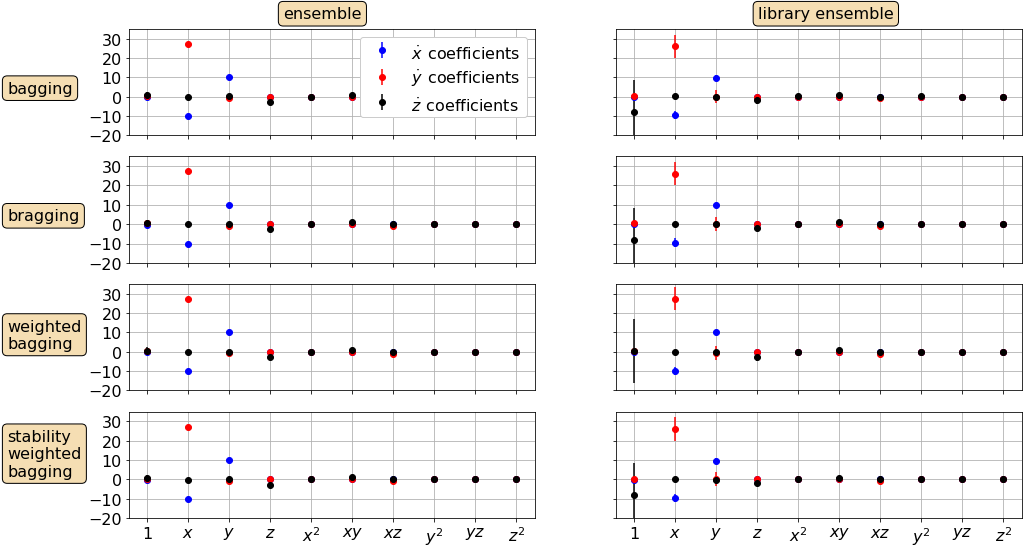

In [6]:
# Plot bagging results with error bars
coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.mean(library_ensemble_coefs, axis=0), 
              e_wavg,
              l_wavg,
              np.median(ensemble_coefs, axis=0),
              np.median(library_ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
              np.mean(stable_library_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             e_wstd,
             l_wstd,
             np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
             np.std(stable_library_ensemble_coefs, axis=0), 
             ]
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top')
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=16, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.1, 'ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    if k == 1:
        ax.text(0.35, 1.1, 'library ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.3, 0.4, textstr, transform=ax.transAxes, fontsize=16, bbox=props)
    else:
        ax.set_yticklabels([])
plt.savefig('ensemble_summary.pdf')

### Repeat ensembling but now make ~100 models and plot the distributions of coefficients

In [7]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=100)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

x' = -9.975 x + 9.906 y
y' = 0.218 1 + 27.235 x + -0.805 y + -0.985 x z
z' = -2.225 1 + -0.224 x + -2.497 z + 0.998 x y


In [8]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=100)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)

x' = -10.008 x + 9.987 y
y' = 6.641 1 + -7.131 x + 20.466 y + 0.157 x y + -0.112 x z + -0.622 y^2
z' = 0.197 1 + -2.673 z + 1.001 x y


['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


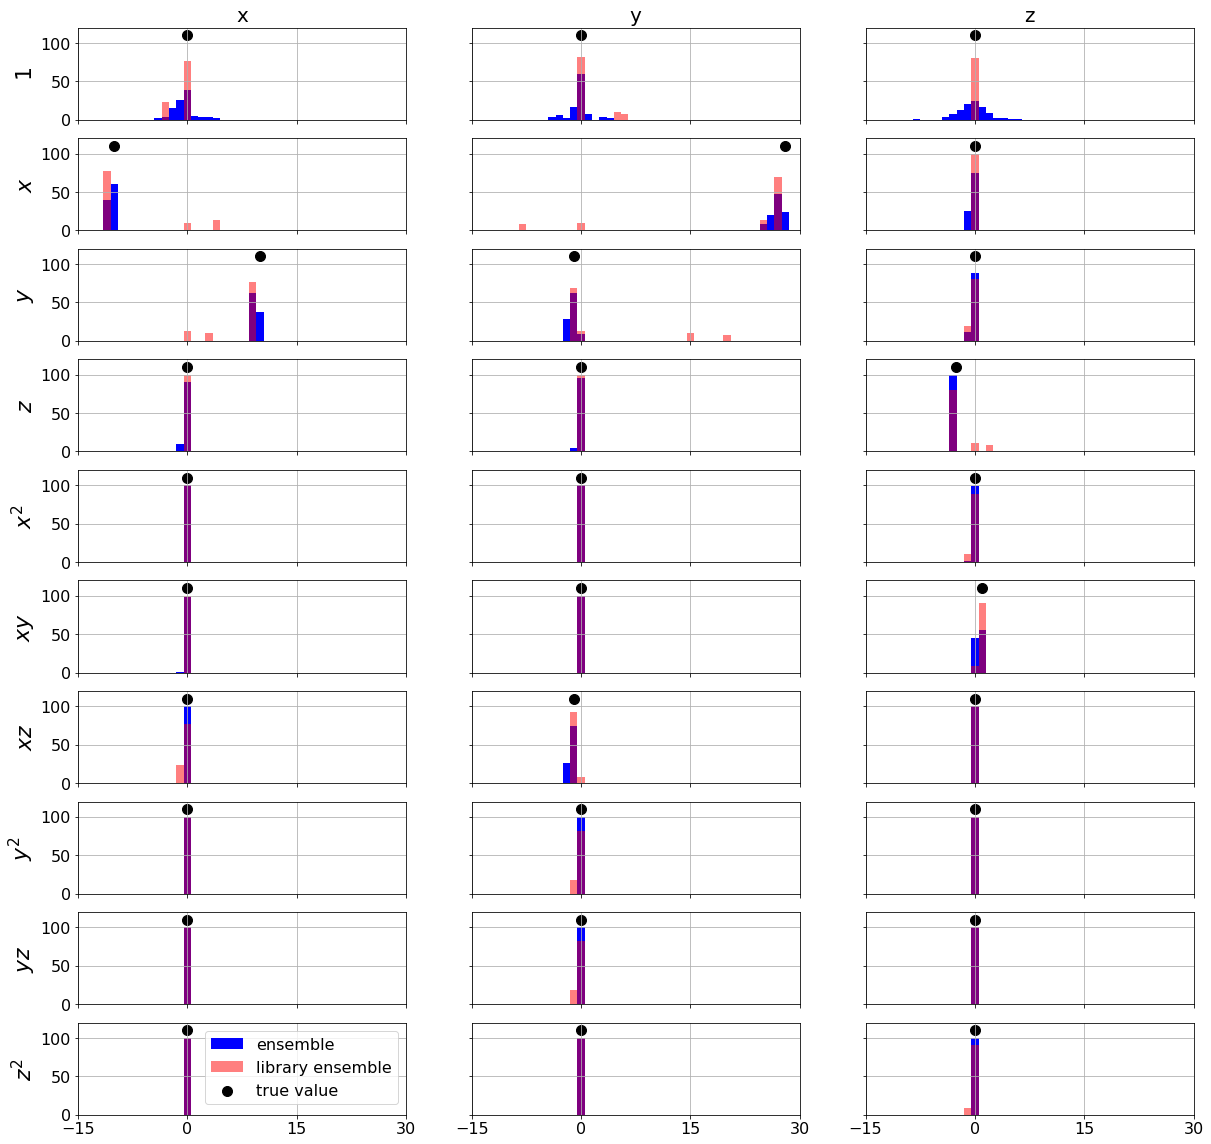

In [9]:
plt.figure(figsize=(20, 20))
min_overall = -15  # min(np.min(ensemble_coefs), np.min(library_ensemble_coefs))
max_overall = 30  # max(np.max(ensemble_coefs), np.max(library_ensemble_coefs))
print(model.get_feature_names())
true_coefs = np.asarray([[0, -10, 10, 0, 0, 0, 0, 0, 0, 0],
                         [0, 28.0, -1, 0, 0, 0, -1, 0, 0, 0],
                         [0, 0, 0, -8.0 / 3.0, 0, 1, 0, 0, 0, 0]])
for j in range(10):
    for i in range(3):

        plt.subplot(10, 3, i + 1 + j * 3)
        if j == 0:
            plt.title(feature_names[i], fontsize=20)
        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        plt.hist(ensemble_coefs[:, i, j], color='b', bins=bins, label='ensemble', align='left')
        plt.hist(library_ensemble_coefs[:, i, j], bins=bins, color='r', alpha=0.5, label='library ensemble', align='left')
        plt.scatter(true_coefs[i, j], 110.0, color='k', label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j], fontsize=22)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 120)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if i == 0 and j == 9:
            plt.legend(fontsize=16)
plt.savefig('lorenz_distributions.pdf')

### Plot 95% percentile bounds with mean and median test trajectories 

In [10]:
# Rerun the ensembling
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=100)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

x' = -0.531 1 + -10.286 x + 10.162 y
y' = 1.978 1 + 26.750 x + -0.719 y + -0.971 x z
z' = -0.513 1 + 0.325 x + -0.305 y + -2.606 z + 0.992 x y


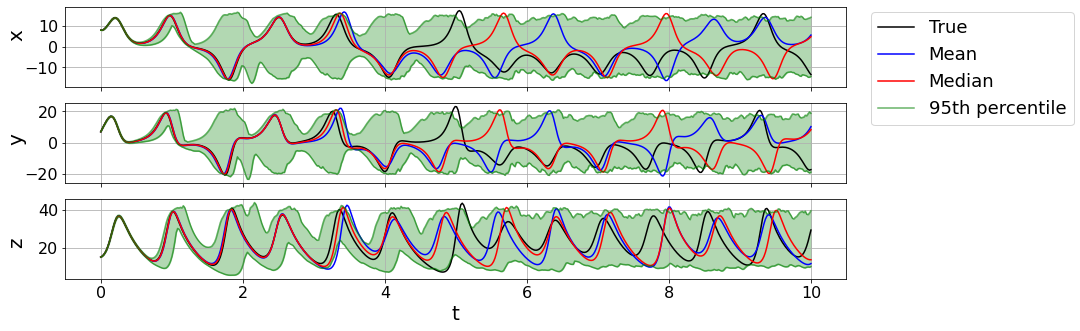

In [11]:
mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
median_ensemble_coefs = np.median(ensemble_coefs, axis=0)
t_test = np.linspace(0, 10, 500)
x_test_sim = odeint(lorenz, x0_test, t_test)  
ensemble_optimizer.coef_ = mean_ensemble_coefs
x_test_sim_mean = model.simulate(x0_test, t_test)
ensemble_optimizer.coef_ = median_ensemble_coefs
x_test_sim_median = model.simulate(x0_test, t_test)

x_test_sims = []
for i in range(ensemble_coefs.shape[0]):
    ensemble_optimizer.coef_ = ensemble_coefs[i, :, :]
    x_test_sims.append(model.simulate(x0_test, t_test))

plt.figure(figsize=(14, 5))
bottom_line = np.percentile(x_test_sims, 2.5, axis=0)
top_line = np.percentile(x_test_sims, 97.5, axis=0)
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_test, x_test_sim[:, i], 'k', label='True')
    plt.plot(t_test, x_test_sim_mean[:, i], 'b', label='Mean')
    plt.plot(t_test, x_test_sim_median[:, i], 'r', label='Median')
    plt.plot(t_test, bottom_line[:, i], 'g', alpha=0.6, label='95th percentile')
    plt.plot(t_test, top_line[:, i], 'g', alpha=0.6)
    ax = plt.gca()
    ax.fill_between(t_test, bottom_line[:, i], top_line[:, i], color='g', alpha=0.3)
    plt.grid(True)
    if i != 2:
        ax.set_xticklabels([])
    else:
        plt.xlabel('t', fontsize=20)
    plt.ylabel(feature_names[i], fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.set_label_coords(-0.05, 0.75 - 0.1 * (i + 1))
    if i == 0:
        ax.legend(bbox_to_anchor=(1.02, 1.05), fontsize=18)
plt.savefig('lorenz_percentile_plot.pdf')

### Variant of ensembling: 
1. Library ensemble and calculate inclusion probabilities
2. Threshold off library terms below some threshold probability
3. Run normal ensemble method with reduced library

This works with similar success with pure ensembling, but this can be very helpful for more complicated, higher-dimensional systems with many library terms.

x' = -2.125 1 + 3.848 x + -0.280 x y + 0.174 y^2
y' = 5.525 1 + 15.715 x + 0.146 x^2 + -0.227 x y + -0.105 x z + -0.460 y^2
z' = 0.197 1 + -2.673 y + 1.001 x^2


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


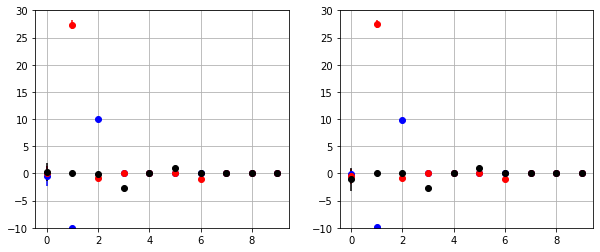

In [12]:
# 1. Library ensemble and calculate inclusion probabilities
n_candidates_to_drop = 1
n_models = 10
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=n_models, 
          n_candidates_to_drop=n_candidates_to_drop)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)
n_targets = len(feature_names)
n_features = len(model.get_feature_names())

# Calculate inclusion probabilities (note you may want to add another factor here because 
# each term is only present for a portion of the fits)
inclusion_probabilities = np.count_nonzero(model.coef_list, axis=0) / n_models

# 2. Chop inclusion probabilities <= 50% (this is rather drastic for illustration)
inclusion_probabilities[inclusion_probabilities <= 0.3] = 0.0

# Find indices that are chopped for all three equations
# since we pass the same library for all.
chopped_inds = np.any(inclusion_probabilities != 0.0, axis=0)
chopped_inds = np.ravel(np.where(~chopped_inds))

# 3. Pass truncated library and then do normal ensembling
library = ps.PolynomialLibrary(degree=2, library_ensemble=True, 
                               ensemble_indices=chopped_inds)
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer, feature_library=library)
model.fit(x_train, t=dt, ensemble=True, n_models=n_models)
two_step_ensemble_coefs = np.asarray(model.coef_list)
two_step_mean = np.mean(two_step_ensemble_coefs, axis=0)
two_step_std = np.std(two_step_ensemble_coefs, axis=0)
two_step_median = np.median(two_step_ensemble_coefs, axis=0)

# Add zeros to get coefficient matrices to original full size
for i in range(len(chopped_inds)):
    two_step_mean = np.insert(two_step_mean, chopped_inds[i], 0.0, axis=-1)
    two_step_std = np.insert(two_step_std, chopped_inds[i], 0.0, axis=-1)
    two_step_median = np.insert(two_step_median, chopped_inds[i], 0.0, axis=-1)

# Compare with pure ensembling 
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=n_models)
ensemble_coefs = np.asarray(model.coef_list)
one_step_mean = np.mean(ensemble_coefs, axis=0)
one_step_std = np.std(ensemble_coefs, axis=0)
one_step_median = np.median(ensemble_coefs, axis=0)

# Plot results
colors = ['b', 'r', 'k']
plt.figure(figsize=(10, 4))
for i in range(n_targets):
    plt.subplot(1, 2, 1)
    plt.errorbar(range(n_features), two_step_mean[i, :], yerr=two_step_std[i, :], 
                 fmt='o', color=colors[i])
    plt.grid(True)
    plt.ylim(-10, 30)
    plt.subplot(1, 2, 2)
    plt.errorbar(range(n_features), one_step_mean[i, :], yerr=one_step_std[i, :], 
                 fmt='o', color=colors[i])
    plt.grid(True)
    plt.ylim(-10, 30)

# Test ensemble functionality with weak-PDE functionality, using the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

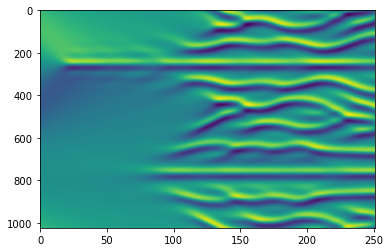

In [13]:
from scipy.io import loadmat 

data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')

In [14]:
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference

# Split into training and testing sets
train = range(0, len(time) // 2, 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Note for ensembling, need to set is_uniform=False
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                        temporal_grid=time, include_bias=True,
                        is_uniform=False, weak_form=True, num_pts_per_domain=50)

# Convert ut into a weak form using the pde_lib
def convert_ut(u, t, pde_lib):
    K = pde_lib.K
    domain_centers = pde_lib.domain_centers
    Hx = pde_lib.Hx
    Ht = pde_lib.Ht
    num_pts_per_domain = pde_lib.num_pts_per_domain
    num_time = len(t)
    ut_integral = np.zeros((K, 1))
    u_shaped = np.reshape(u, (len(x), len(t)))
    u_interp = RectBivariateSpline(x, t, u_shaped)
    for k in range(K):
        X = np.ravel(pde_lib.X[k, :, :])
        t = np.ravel(pde_lib.t[k, :, :])
        u_new = u_interp.ev(X, t)
        u_new = np.reshape(u_new, (num_pts_per_domain,
                                   num_pts_per_domain,
                                   1))
        w_diff = pde_lib._smooth_ppoly(
                    np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                    pde_lib.tgrid_k[k, :], k, 0, 0, 1
                )
        ut_integral[k] = (-1) * (
            trapezoid(
                trapezoid(
                    u_new * w_diff, x=pde_lib.xgrid_k[k, :], axis=0
                ),
                x=pde_lib.tgrid_k[k, :], axis=0
            )
        )
    return ut_integral

ut_train_integral = convert_ut(u_train, t_train, pde_lib)
ut_test_integral = convert_ut(u_test, t_test, pde_lib)
ut_integral = convert_ut(u, time, pde_lib)

In [15]:
optimizer = ps.SR3(threshold=0.1, max_iter=500, tol=1e-5, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral, ensemble=True, n_models=20, n_subset=len(time) // 2)
model.print()
weak_KS_models = np.asarray(model.coef_list)
mean_weak_KS_models = np.mean(weak_KS_models, axis=0)
median_weak_KS_models = np.median(weak_KS_models, axis=0)
print(mean_weak_KS_models)
print(median_weak_KS_models)

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/opt

x0' = -1.007 x0_11 + -0.963 x0_1111 + -0.987 x0x0_1 + 0.003 x0x0x0_1 + 0.002 x0x0_11 + 0.003 x0x0x0_11 + 0.007 x0x0_111 + 0.001 x0x0_1111 + 0.002 x0x0x0_1111
[[ 1.49266598e-06  3.13412737e-05  2.80738035e-05  2.60946747e-04
  -1.00017828e+00  1.50039801e-02 -1.00252755e+00 -9.98986772e-01
   1.20358670e-03  4.51321054e-04  2.35024526e-03  2.27814670e-03
  -9.77133265e-05  3.18035772e-04  2.22679750e-03]]
[[ 0.00000000e+00  0.00000000e+00 -1.34732395e-05  0.00000000e+00
  -1.00072183e+00  0.00000000e+00 -1.00964893e+00 -1.00208115e+00
   0.00000000e+00  1.71186288e-04  1.96912820e-03  0.00000000e+00
   0.00000000e+00  2.48745718e-04  1.96157430e-03]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


In [16]:
def model_error(KS_pred_coef, KS_true_coef):
    nonzero_inds = (KS_true_coef != 0.0)
    return np.sqrt((KS_true_coef[nonzero_inds] - KS_pred_coef[nonzero_inds]) ** 2)

def success_rate(KS_pred_coef, KS_true_coef):
    return 1 - np.sum(np.sqrt((KS_true_coef - KS_pred_coef) ** 2))

In [17]:
print(model.get_feature_names())
KS_true = np.zeros((1, 15))
KS_true[0, 4] = -1.0
KS_true[0, 6] = -1.0
KS_true[0, 7] = -1.0
print(model_error(mean_weak_KS_models, KS_true))
print(model_error(median_weak_KS_models, KS_true))
print(success_rate(median_weak_KS_models, KS_true))

['1', 'x0', 'x0x0', 'x0_1', 'x0_11', 'x0_111', 'x0_1111', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11', 'x0x0_111', 'x0x0x0_111', 'x0x0_1111', 'x0x0x0_1111']
[0.00017828 0.00252755 0.00101323]
[0.00072183 0.00964893 0.00208115]
0.9831839778343587
